In [56]:
import pandas as pd
import numpy as np
import spacy
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [57]:
df = pd.read_csv('tripadvisor_qatar_airways_reviews.csv', index_col=0)
df.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class
0,yIkwg343,NaN,Top Servie!! Professioneller Service. Bin 4 St...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
1,sEPNCE5c,NaN,Die Airline mag an sich ok sein (aber 1. Klass...,1.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
2,Gbpa6Vkh,NaN,Top Airlines\nEssen und Bewirtung fantastisch\...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
3,FhRbdHy3,NaN,Service und Flugzeug im Großen und Ganzen Okay...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
4,xqlo91bd,NaN,In der Economy-Klasse sind die Sitze ziemlich ...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN


In [58]:
# Initialize german language model
##download and install the model
##pip install spacy
##pip install -U pip setuptools wheel
##pip install -U spacy
##python -m spacy download en_core_web_sm
nlp = spacy.load("de_core_news_sm")

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _id                5 non-null      object 
 1   title              0 non-null      float64
 2   text               5 non-null      object 
 3   rating             5 non-null      float64
 4   reviewer_handle    0 non-null      float64
 5   language           0 non-null      float64
 6   airline_name       5 non-null      object 
 7   flight_date        0 non-null      float64
 8   flight_connection  0 non-null      float64
 9   flight_type        0 non-null      float64
 10  booking_class      0 non-null      float64
dtypes: float64(8), object(3)
memory usage: 480.0+ bytes


In [60]:
df[df['rating'] == 5.0]

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class
0,yIkwg343,NaN,Top Servie!! Professioneller Service. Bin 4 St...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN
2,Gbpa6Vkh,NaN,Top Airlines\nEssen und Bewirtung fantastisch\...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN


In [61]:
# Add sentiment label pos, neu, neg
def categorize(rating):

    if rating >= 4.0:
        return 'positive'
    elif rating == 3.0:
        return 'neutral'
    else:
        return 'negative'

<AxesSubplot: >

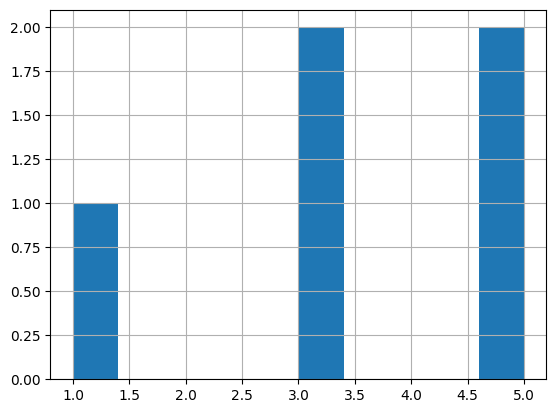

In [62]:
# Rating Distribution
df['rating'].hist()

In [63]:
df['sentiment'] = df['rating'].apply(categorize)

<AxesSubplot: >

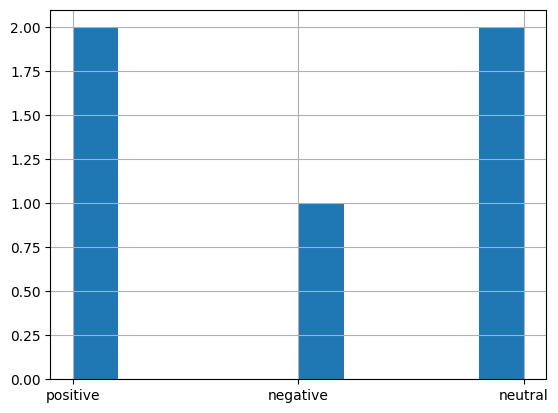

In [64]:
df['sentiment'].hist()

In [65]:
# Sentiment to target number
target_map = {'positive':1, 'negative':0, 'neutral':2}
df['target'] = df['sentiment'].map(target_map)

In [66]:
# Preprocessing

def lower(review):
    return review.lower()

def remove_stopwords(review):
    
    doc = nlp(review)
    filtered_tokens = [token.text for token in doc if not token.is_stop]
    review = ' '.join(filtered_tokens)
    
    return review

def remove_punct(review):
    
    pattern = r'[^a-zA-ZäöüÄÖÜß\s]'
    review = re.sub(pattern, '', review)
    return review

def remove_trailing_newlines(review):

    pattern = r'\n+$'
    review = re.sub(pattern, '', review)
    return review

def lemmatize(review):
    
    doc = nlp(review)
    lemmatized_tokens = [token.lemma_ for token in doc]
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text

def replace_spaces(review):
    review = re.sub(r'\s+', ' ', review)
    return review
    

In [67]:
# Preprocessing

df['text'] = df['text'].apply(lower)
df['text'] = df['text'].apply(remove_stopwords)
df['text'] = df['text'].apply(remove_punct)
df['text'] = df['text'].apply(remove_trailing_newlines)
df['text'] = df['text'].apply(lemmatize)
df['text'] = df['text'].apply(replace_spaces)

In [68]:
df.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class,sentiment,target
0,yIkwg343,NaN,top servie professionell Service Strecke qatar...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,positive,1
1,sEPNCE5c,NaN,airlinen ok Klasse definitiv ärgern folgend Fl...,1.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,negative,0
2,Gbpa6Vkh,NaN,top airlines ess Bewirtung fantastisch einfach...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,positive,1
3,FhRbdHy3,NaN,Service Flugzeug Okay stören Kundenservice Bez...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,neutral,2
4,xqlo91bd,NaN,economyklasse sitzen ziemlich eng unangenehm e...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,neutral,2


In [69]:
# Training

# Train-Test split
df_train, df_test =train_test_split(df)

In [70]:
df_train.head()

,_id,title,text,rating,reviewer_handle,language,airline_name,flight_date,flight_connection,flight_type,booking_class,sentiment,target
3,FhRbdHy3,NaN,Service Flugzeug Okay stören Kundenservice Bez...,3.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,neutral,2
2,Gbpa6Vkh,NaN,top airlines ess Bewirtung fantastisch einfach...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,positive,1
0,yIkwg343,NaN,top servie professionell Service Strecke qatar...,5.0,NaN,NaN,Emirates,NaN,NaN,NaN,NaN,positive,1


In [71]:
vectorizer = TfidfVectorizer(max_features=50)

In [72]:
X_train = vectorizer.fit_transform(df_train['text'])

In [73]:
X_train

<3x50 sparse matrix of type '<class 'numpy.float64'>'
	with 53 stored elements in Compressed Sparse Row format>

In [74]:
X_test = vectorizer.transform(df_test['text'])

In [82]:
Y_train = df_train['target']
Y_test = df_test['target']

In [83]:
model = LogisticRegression(max_iter=500)
model.fit(X_train, Y_train)
print("Train Acc:", model.score(X_train, Y_train))
print("Test Acc:", model.score(X_test, Y_test))

Train Acc: 0.6666666666666666
Test Acc: 0.0


In [55]:
Pr_train = model.predict_proba(X_train)
Pr_test = model.predict_proba(X_test)

#print("Train AUC-ROC:", roc_auc_score(Y_train_1d, Pr_train_1d , multi_class='ovo'))
#print("Test AUC-ROC:", roc_auc_score(Y_test_1d, Pr_test_1d , multi_class='ovo'))


In [87]:
num_samples_Y = Y_train.shape[0]
num_samples_Pr = Pr_train.shape[0]
if num_samples_Y != num_samples_Pr:
    raise ValueError("Number of samples in Y_train and Pr_train must be the same")

In [25]:
P_train = model.predict(X_train)
P_test = model.predict(X_test)

In [26]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[1., 0.],
       [1., 0.]])